<a href="https://colab.research.google.com/github/wobiero/Madagascar-CEA/blob/main/malmquist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install pydea

In [3]:
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory, minimize, NonNegativeReals, ConstraintList, TerminationCondition
import pandas as pd
import numpy as np
from google.colab import files
import io

In [4]:
!apt-get install -y -qq glpk-utils

In [5]:
import os
# Get the path to the glpsol executable
glpk_executable_path = '/usr/bin/glpsol'  # Update with the actual path if different

# Set the solver path in the SolverFactory call
solver = SolverFactory('glpk', executable=glpk_executable_path)

In [6]:
uploaded = files.upload()

Saving trial_data.dta to trial_data (1).dta


In [8]:
df = pd.read_stata(io.BytesIO(uploaded["trial_data (1).dta"]))
df[:5]

,measure_id,dmu,metric_id,year,mmr,hale,population,le,sev,Region,...,l_healthworkforce,l_women_education,l_water,l_electricity,l_childsurvival,l_mumsurvival,l_Immunization,l_hale,l_le,province
0,25,Kiambu,3,2014,250.185242,57.720318,2.101640e+06,65.250183,24.783125,Central,...,0.615186,4.138361,4.185708,4.069540,3.270169,1.385554,4.560173,4.055609,4.178229,Central
1,25,Murang'a,3,2014,320.207550,59.237213,9.980449e+05,67.268967,27.125710,Central,...,1.205971,3.914021,4.042349,3.737670,3.101093,1.138786,4.551769,4.081550,4.208699,Central
2,25,Wajir,3,2014,686.670776,53.548244,8.050101e+05,61.373489,27.379135,North Eastern,...,0.708036,2.251292,3.582963,2.606387,3.352407,0.375900,4.257030,3.980583,4.116978,North Eastern
3,25,Kirinyaga,3,2014,302.703979,58.558018,5.914555e+05,66.560234,27.778282,Central,...,0.837248,3.749504,4.014038,3.806440,3.244194,1.195000,4.558079,4.070018,4.198107,Central
4,25,Kwale,3,2014,455.698303,55.843388,7.945485e+05,63.943008,27.938898,Coast,...,1.015231,3.034953,4.003508,3.183041,2.813411,0.785924,4.546481,4.022551,4.157992,Coast


In [23]:
df_2014 = df[df["year"] == 2014]
df_2022 = df[df["year"] == 2022]
df_2014[:5]

,measure_id,dmu,metric_id,year,mmr,hale,population,le,sev,Region,...,l_healthworkforce,l_women_education,l_water,l_electricity,l_childsurvival,l_mumsurvival,l_Immunization,l_hale,l_le,province
0,25,Kiambu,3,2014,250.185242,57.720318,2.101640e+06,65.250183,24.783125,Central,...,0.615186,4.138361,4.185708,4.069540,3.270169,1.385554,4.560173,4.055609,4.178229,Central
1,25,Murang'a,3,2014,320.207550,59.237213,9.980449e+05,67.268967,27.125710,Central,...,1.205971,3.914021,4.042349,3.737670,3.101093,1.138786,4.551769,4.081550,4.208699,Central
2,25,Wajir,3,2014,686.670776,53.548244,8.050101e+05,61.373489,27.379135,North Eastern,...,0.708036,2.251292,3.582963,2.606387,3.352407,0.375900,4.257030,3.980583,4.116978,North Eastern
3,25,Kirinyaga,3,2014,302.703979,58.558018,5.914555e+05,66.560234,27.778282,Central,...,0.837248,3.749504,4.014038,3.806440,3.244194,1.195000,4.558079,4.070018,4.198107,Central
4,25,Kwale,3,2014,455.698303,55.843388,7.945485e+05,63.943008,27.938898,Coast,...,1.015231,3.034953,4.003508,3.183041,2.813411,0.785924,4.546481,4.022551,4.157992,Coast


In [24]:
inputs_2014 = df_2014[['l_pop_dev', 'l_healthworkforce', 'l_women_education', 'l_water', 'l_better_nutrition']].values
outputs_2014 = df_2014[['l_childsurvival']].values

inputs_2022 = df_2022[['l_pop_dev', 'l_healthworkforce', 'l_women_education', 'l_water', 'l_better_nutrition']].values
outputs_2022 = df_2022[['l_childsurvival']].values

In [28]:
# Function to calculate efficiency
def calculate_efficiency(inputs, outputs, frontier_inputs, frontier_outputs, solver): # Added solver as an argument
    efficiencies = []
    for i in range(len(inputs)):
        model = ConcreteModel()

        # Variables
        model.lambdas = Var(range(len(frontier_inputs)), domain=NonNegativeReals)
        model.efficiency = Var(domain=NonNegativeReals)

        # Objective function
        model.obj = Objective(expr=model.efficiency, sense=minimize)

        # Constraints
        model.constraints = ConstraintList()
        for j in range(inputs.shape[1]):  # Inputs
            model.constraints.add(
                sum(model.lambdas[k] * frontier_inputs[k, j] for k in range(len(frontier_inputs))) <= inputs[i, j]
            )
        for j in range(outputs.shape[1]):  # Outputs
            model.constraints.add(
                sum(model.lambdas[k] * frontier_outputs[k, j] for k in range(len(frontier_outputs))) >= model.efficiency * outputs[i, j]
            )
        model.constraints.add(sum(model.lambdas[k] for k in range(len(frontier_inputs))) == 1)

        # Solve the model
        # solver = SolverFactory('glpk')  # Removed this line to use the solver passed as an argument
        result = solver.solve(model, tee=False) # Using the solver passed as argument

        # Check if the solution is optimal and append the efficiency value,
        # otherwise append 1 (or another suitable value) to avoid None values
        if result.solver.termination_condition == TerminationCondition.optimal:
            efficiencies.append(model.efficiency())
        else:
            efficiencies.append(1)  # Replace 1 with a suitable value if needed

    return np.array(efficiencies)

# Calculate efficiency for each year, passing the solver instance
eff_2014_2014 = calculate_efficiency(inputs_2014, outputs_2014, inputs_2014, outputs_2014, solver)  # Pass solver here
eff_2022_2022 = calculate_efficiency(inputs_2022, outputs_2022, inputs_2022, outputs_2022, solver)  # Pass solver here
eff_2014_2022 = calculate_efficiency(inputs_2014, outputs_2014, inputs_2022, outputs_2022, solver)  # Pass solver here
eff_2022_2014 = calculate_efficiency(inputs_2022, outputs_2022, inputs_2014, outputs_2014, solver)  # Pass solver here
# Compute MPI
mpi = np.sqrt((eff_2022_2022 / eff_2014_2022) * (eff_2022_2014 / eff_2014_2014))

# Output results
results = pd.DataFrame({
    'DMU': df_2014['dmu'],
    'MPI': mpi
})
print(results)

                DMU  MPI
0            Kiambu  NaN
1          Murang'a  NaN
2             Wajir  NaN
3         Kirinyaga  NaN
4             Kwale  NaN
5           Mandera  NaN
6              Meru  NaN
7       TaitaTaveta  NaN
8           Kajiado  NaN
9          Marsabit  NaN
10           Migori  NaN
11          Nairobi  NaN
12           Vihiga  NaN
13          Mombasa  NaN
14            Siaya  NaN
15           Kilifi  NaN
16             Lamu  NaN
17          HomaBay  NaN
18       UasinGishu  0.0
19          Makueni  NaN
20           Kisumu  NaN
21            Busia  NaN
22          Nyamira  NaN
23            Narok  NaN
24          Samburu  NaN
25          Baringo  NaN
26         Machakos  NaN
27        WestPokot  NaN
28            Kisii  NaN
29           Isiolo  NaN
30        Nyandarua  NaN
31            Nandi  NaN
32            Nyeri  NaN
33         Laikipia  NaN
34  Elgeyo-Marakwet  NaN
35         Kakamega  NaN
36       TransNzoia  NaN
37        TanaRiver  NaN
38             Embu  NaN


<ipython-input-28-6dd8a87d7fa0>:45: RuntimeWarning: invalid value encountered in divide
  mpi = np.sqrt((eff_2022_2022 / eff_2014_2022) * (eff_2022_2014 / eff_2014_2014))
<ipython-input-28-6dd8a87d7fa0>:45: RuntimeWarning: divide by zero encountered in divide
  mpi = np.sqrt((eff_2022_2022 / eff_2014_2022) * (eff_2022_2014 / eff_2014_2014))
<ipython-input-28-6dd8a87d7fa0>:45: RuntimeWarning: invalid value encountered in multiply
  mpi = np.sqrt((eff_2022_2022 / eff_2014_2022) * (eff_2022_2014 / eff_2014_2014))


In [29]:
print("Inputs 2014:\n", inputs_2014)
print("\nOutputs 2014:\n", outputs_2014)

Inputs 2014:
 [[3.3645535  0.6151856  4.1383615  4.1857076  3.0256717 ]
 [3.516425   1.2059708  3.914021   4.0423493  2.9368918 ]
 [4.448787   0.70803577 2.2512918  3.5829632  1.7473437 ]
 [3.9921057  0.83724755 3.749504   4.014038   2.6381292 ]
 [4.316958   1.0152307  3.0349529  4.0035076  2.248612  ]
 [3.9068582  1.0612565  2.3978953  3.440418   1.6126456 ]
 [3.1217153  0.97077894 3.468856   3.9577608  2.5911927 ]
 [4.153205   1.9329697  3.7281     3.9897244  2.626154  ]
 [3.3347948  1.7173951  3.9569964  4.103965   2.5911927 ]
 [4.071504   0.7654678  2.5494452  3.676807   1.4637783 ]
 [3.6214614  1.1118575  3.198673   3.9884284  2.5359092 ]
 [2.7837093  0.5007753  4.206184   4.1779194  3.3074648 ]
 [3.162538   0.53649336 3.7841897  4.238301   2.887543  ]
 [3.4491103  1.2697605  3.9019728  4.040768   2.4350743 ]
 [3.601393   1.2919837  3.5467396  3.9734943  2.626154  ]
 [3.8268397  0.6729445  3.3068867  3.9632864  1.9340053 ]
 [4.9899487  2.631169   3.1738784  3.9114227  2.248612  ]


In [30]:
from pyomo.opt import TerminationCondition

def calculate_efficiency(inputs, outputs, frontier_inputs, frontier_outputs, solver):
    efficiencies = []
    for i in range(len(inputs)):
        model = ConcreteModel()

        # Variables
        model.lambdas = Var(range(len(frontier_inputs)), domain=NonNegativeReals)
        model.efficiency = Var(domain=NonNegativeReals)

        # Objective function
        model.obj = Objective(expr=model.efficiency, sense=minimize)

        # Constraints
        model.constraints = ConstraintList()
        for j in range(inputs.shape[1]):  # Inputs
            model.constraints.add(
                sum(model.lambdas[k] * frontier_inputs[k, j] for k in range(len(frontier_inputs))) <= inputs[i, j]
            )
        for j in range(outputs.shape[1]):  # Outputs
            model.constraints.add(
                sum(model.lambdas[k] * frontier_outputs[k, j] for k in range(len(frontier_outputs))) >= model.efficiency * outputs[i, j]
            )
        model.constraints.add(sum(model.lambdas[k] for k in range(len(frontier_inputs))) == 1)

        # Solve the model
        result = solver.solve(model, tee=True)

        # Log the termination condition
        print(f"DMU {i}: Termination condition - {result.solver.termination_condition}")

        # Check if the solution is optimal
        if result.solver.termination_condition == TerminationCondition.optimal:
            efficiencies.append(model.efficiency())
        else:
            efficiencies.append(np.nan)  # Append NaN for non-optimal solutions to identify problems

    return np.array(efficiencies)


In [32]:
# import numpy as np
# import pandas as pd
# from pyomo.environ import (ConcreteModel, Var, Objective, Constraint,
#                          SolverFactory, minimize, NonNegativeReals,
#                          ConstraintList, TerminationCondition)
# from scipy import stats

def calculate_efficiency(inputs, outputs, frontier_inputs, frontier_outputs, solver, dmu_index=None):
    """
    Calculate efficiency scores using DEA.
    Added debugging and better error handling.
    """
    efficiencies = []
    for i in range(len(inputs)):
        model = ConcreteModel()

        # Variables
        model.lambdas = Var(range(len(frontier_inputs)), domain=NonNegativeReals)
        model.efficiency = Var(domain=NonNegativeReals, initialize=1.0)

        # Objective
        model.obj = Objective(expr=model.efficiency, sense=minimize)

        # Constraints
        model.constraints = ConstraintList()

        # Input constraints
        for j in range(inputs.shape[1]):
            model.constraints.add(
                sum(model.lambdas[k] * frontier_inputs[k, j]
                    for k in range(len(frontier_inputs))) <= inputs[i, j]
            )

        # Output constraints
        for j in range(outputs.shape[1]):
            model.constraints.add(
                sum(model.lambdas[k] * frontier_outputs[k, j]
                    for k in range(len(frontier_outputs))) >= model.efficiency * outputs[i, j]
            )

        # Convexity constraint
        model.constraints.add(
            sum(model.lambdas[k] for k in range(len(frontier_inputs))) == 1
        )

        # Solve with error handling
        try:
            result = solver.solve(model, tee=False)

            if (result.solver.status.key == 'ok' and
                result.solver.termination_condition == TerminationCondition.optimal):
                eff_value = model.efficiency()

                # Add validation
                if eff_value <= 0 or np.isnan(eff_value):
                    print(f"Warning: Invalid efficiency value {eff_value} for DMU {dmu_index if dmu_index is not None else i}")
                    eff_value = 1.0

                efficiencies.append(eff_value)
            else:
                print(f"Warning: Non-optimal solution for DMU {dmu_index if dmu_index is not None else i}")
                efficiencies.append(1.0)

        except Exception as e:
            print(f"Error solving DEA for DMU {dmu_index if dmu_index is not None else i}: {str(e)}")
            efficiencies.append(1.0)

    return np.array(efficiencies)

def calculate_mpi_with_decomposition(inputs_t, outputs_t, inputs_t1, outputs_t1, solver, dmu_indices=None):
    """
    Calculate MPI and its decomposition into technical change and efficiency change.
    """
    # Calculate efficiencies
    eff_t_t = calculate_efficiency(inputs_t, outputs_t, inputs_t, outputs_t, solver, dmu_indices)
    eff_t1_t1 = calculate_efficiency(inputs_t1, outputs_t1, inputs_t1, outputs_t1, solver, dmu_indices)
    eff_t_t1 = calculate_efficiency(inputs_t, outputs_t, inputs_t1, outputs_t1, solver, dmu_indices)
    eff_t1_t = calculate_efficiency(inputs_t1, outputs_t1, inputs_t, outputs_t, solver, dmu_indices)

    # Calculate components
    efficiency_change = eff_t1_t1 / eff_t_t
    technical_change = np.sqrt((eff_t_t / eff_t_t1) * (eff_t1_t / eff_t1_t1))
    mpi = efficiency_change * technical_change

    return mpi, technical_change, efficiency_change

def bootstrap_mpi(inputs_t, outputs_t, inputs_t1, outputs_t1, solver,
                 n_bootstrap=1000, alpha=0.05):
    """
    Perform bootstrap to get confidence intervals for MPI.
    """
    n_dmus = len(inputs_t)
    mpi_boots = np.zeros((n_bootstrap, n_dmus))
    tech_boots = np.zeros((n_bootstrap, n_dmus))
    eff_boots = np.zeros((n_bootstrap, n_dmus))

    for b in range(n_bootstrap):
        # Generate bootstrap sample indices
        indices = np.random.choice(n_dmus, size=n_dmus, replace=True)

        # Get bootstrap samples
        inputs_t_boot = inputs_t[indices]
        outputs_t_boot = outputs_t[indices]
        inputs_t1_boot = inputs_t1[indices]
        outputs_t1_boot = outputs_t1[indices]

        # Calculate MPI for bootstrap sample
        mpi_b, tech_b, eff_b = calculate_mpi_with_decomposition(
            inputs_t_boot, outputs_t_boot,
            inputs_t1_boot, outputs_t1_boot,
            solver, indices
        )

        mpi_boots[b] = mpi_b
        tech_boots[b] = tech_b
        eff_boots[b] = eff_b

    # Calculate confidence intervals
    ci_lower = alpha / 2
    ci_upper = 1 - alpha / 2

    mpi_ci = np.percentile(mpi_boots, [ci_lower * 100, ci_upper * 100], axis=0)
    tech_ci = np.percentile(tech_boots, [ci_lower * 100, ci_upper * 100], axis=0)
    eff_ci = np.percentile(eff_boots, [ci_lower * 100, ci_upper * 100], axis=0)

    return mpi_ci, tech_ci, eff_ci

def main(df):
    # Split data by year
    df_2014 = df[df["year"] == 2014]
    df_2022 = df[df["year"] == 2022]

    # Prepare inputs and outputs
    input_cols = ['l_pop_dev', 'l_healthworkforce', 'l_women_education',
                 'l_water', 'l_better_nutrition']
    output_cols = ['l_childsurvival']

    inputs_2014 = df_2014[input_cols].values
    outputs_2014 = df_2014[output_cols].values
    inputs_2022 = df_2022[input_cols].values
    outputs_2022 = df_2022[output_cols].values

    # Initialize solver
    solver = SolverFactory('glpk')

    # Calculate MPI and decomposition
    mpi, tech_change, eff_change = calculate_mpi_with_decomposition(
        inputs_2014, outputs_2014,
        inputs_2022, outputs_2022,
        solver
    )

    # Calculate bootstrap confidence intervals
    mpi_ci, tech_ci, eff_ci = bootstrap_mpi(
        inputs_2014, outputs_2014,
        inputs_2022, outputs_2022,
        solver
    )

    # Create results DataFrame
    results = pd.DataFrame({
        'DMU': df_2014['dmu'],
        'MPI': mpi,
        'MPI_CI_Lower': mpi_ci[0],
        'MPI_CI_Upper': mpi_ci[1],
        'Technical_Change': tech_change,
        'Tech_CI_Lower': tech_ci[0],
        'Tech_CI_Upper': tech_ci[1],
        'Efficiency_Change': eff_change,
        'Eff_CI_Lower': eff_ci[0],
        'Eff_CI_Upper': eff_ci[1]
    })

    return results

# Example usage:
# results = main(df)
# print(results)

In [35]:
!which glpsol

/usr/bin/glpsol


In [38]:
import numpy as np
import pandas as pd
from pyomo.environ import (ConcreteModel, Var, Objective, Constraint,
                         SolverFactory, minimize, NonNegativeReals,
                         ConstraintList, TerminationCondition)
import numpy.random as random

def calculate_efficiency(inputs, outputs, frontier_inputs, frontier_outputs, solver, dmu_index=None):
    """
    Calculate efficiency scores using DEA with corrected solver status checking.
    """
    efficiencies = []
    for i in range(len(inputs)):
        model = ConcreteModel()

        # Variables
        model.lambdas = Var(range(len(frontier_inputs)), domain=NonNegativeReals)
        model.efficiency = Var(domain=NonNegativeReals, initialize=1.0)

        # Objective
        model.obj = Objective(expr=model.efficiency, sense=minimize)

        # Constraints
        model.constraints = ConstraintList()

        # Input constraints
        for j in range(inputs.shape[1]):
            model.constraints.add(
                sum(model.lambdas[k] * frontier_inputs[k, j]
                    for k in range(len(frontier_inputs))) <= inputs[i, j]
            )

        # Output constraints
        for j in range(outputs.shape[1]):
            model.constraints.add(
                sum(model.lambdas[k] * frontier_outputs[k, j]
                    for k in range(len(frontier_outputs))) >= model.efficiency * outputs[i, j]
            )

        # Convexity constraint
        model.constraints.add(
            sum(model.lambdas[k] for k in range(len(frontier_inputs))) == 1
        )

        # Solve with error handling
        try:
            result = solver.solve(model, tee=False)

            # Corrected solver status check
            if (result.solver.termination_condition == TerminationCondition.optimal):
                eff_value = model.efficiency()

                # Add validation
                if eff_value <= 0 or np.isnan(eff_value):
                    print(f"Warning: Invalid efficiency value {eff_value} for DMU {dmu_index if dmu_index is not None else i}")
                    eff_value = 1.0

                efficiencies.append(eff_value)
            else:
                print(f"Warning: Non-optimal solution for DMU {dmu_index if dmu_index is not None else i}")
                print(f"Termination condition: {result.solver.termination_condition}")
                efficiencies.append(1.0)

        except Exception as e:
            print(f"Error solving DEA for DMU {dmu_index if dmu_index is not None else i}: {str(e)}")
            efficiencies.append(1.0)

    return np.array(efficiencies)

def calculate_mpi_with_decomposition(inputs_t, outputs_t, inputs_t1, outputs_t1, solver, dmu_indices=None):
    """
    Calculate MPI and its decomposition into technical change and efficiency change.
    """
    # Calculate efficiencies
    eff_t_t = calculate_efficiency(inputs_t, outputs_t, inputs_t, outputs_t, solver, dmu_indices)
    eff_t1_t1 = calculate_efficiency(inputs_t1, outputs_t1, inputs_t1, outputs_t1, solver, dmu_indices)
    eff_t_t1 = calculate_efficiency(inputs_t, outputs_t, inputs_t1, outputs_t1, solver, dmu_indices)
    eff_t1_t = calculate_efficiency(inputs_t1, outputs_t1, inputs_t, outputs_t, solver, dmu_indices)

    # Print efficiency values for debugging
    print("\nEfficiency values:")
    print(f"eff_t_t: {eff_t_t}")
    print(f"eff_t1_t1: {eff_t1_t1}")
    print(f"eff_t_t1: {eff_t_t1}")
    print(f"eff_t1_t: {eff_t1_t}")

    # Calculate components with safety checks
    efficiency_change = np.divide(eff_t1_t1, eff_t_t, out=np.ones_like(eff_t1_t1), where=eff_t_t!=0)

    # Calculate technical change with safety checks
    term1 = np.divide(eff_t_t, eff_t_t1, out=np.ones_like(eff_t_t), where=eff_t_t1!=0)
    term2 = np.divide(eff_t1_t, eff_t1_t1, out=np.ones_like(eff_t1_t), where=eff_t1_t1!=0)
    technical_change = np.sqrt(term1 * term2)

    mpi = efficiency_change * technical_change

    return mpi, technical_change, efficiency_change

def bootstrap_mpi(inputs_t, outputs_t, inputs_t1, outputs_t1, solver,
                 n_bootstrap=1000, alpha=0.05):
    """
    Perform bootstrap to get confidence intervals for MPI.
    """
    n_dmus = len(inputs_t)
    mpi_boots = np.zeros((n_bootstrap, n_dmus))
    tech_boots = np.zeros((n_bootstrap, n_dmus))
    eff_boots = np.zeros((n_bootstrap, n_dmus))

    for b in range(n_bootstrap):
        if b % 100 == 0:
            print(f"Bootstrap iteration {b}/{n_bootstrap}")

        # Generate bootstrap sample indices
        indices = random.choice(n_dmus, size=n_dmus, replace=True)

        # Get bootstrap samples
        inputs_t_boot = inputs_t[indices]
        outputs_t_boot = outputs_t[indices]
        inputs_t1_boot = inputs_t1[indices]
        outputs_t1_boot = outputs_t1[indices]

        # Calculate MPI for bootstrap sample
        mpi_b, tech_b, eff_b = calculate_mpi_with_decomposition(
            inputs_t_boot, outputs_t_boot,
            inputs_t1_boot, outputs_t1_boot,
            solver, indices
        )

        mpi_boots[b] = mpi_b
        tech_boots[b] = tech_b
        eff_boots[b] = eff_b

    # Calculate confidence intervals
    ci_lower = alpha / 2
    ci_upper = 1 - alpha / 2

    mpi_ci = np.percentile(mpi_boots, [ci_lower * 100, ci_upper * 100], axis=0)
    tech_ci = np.percentile(tech_boots, [ci_lower * 100, ci_upper * 100], axis=0)
    eff_ci = np.percentile(eff_boots, [ci_lower * 100, ci_upper * 100], axis=0)

    return mpi_ci, tech_ci, eff_ci

# Main execution code
def run_analysis(df):
    """
    Run the complete MPI analysis on the provided dataframe.
    """
    # Initialize solver
    solver = SolverFactory('glpk', executable='/usr/bin/glpsol')

    # Split data by year
    df_2014 = df[df["year"] == 2014]
    df_2022 = df[df["year"] == 2022]

    # Prepare inputs and outputs
    input_cols = ['l_pop_dev', 'l_healthworkforce', 'l_women_education',
                 'l_water', 'l_better_nutrition']
    output_cols = ['l_childsurvival']

    # Print data info
    print("\nData shapes:")
    print(f"2014 data: {df_2014.shape}")
    print(f"2022 data: {df_2022.shape}")

    inputs_2014 = df_2014[input_cols].values
    outputs_2014 = df_2014[output_cols].values
    inputs_2022 = df_2022[input_cols].values
    outputs_2022 = df_2022[output_cols].values

    # Calculate base MPI and decomposition
    print("\nCalculating base MPI...")
    mpi, tech_change, eff_change = calculate_mpi_with_decomposition(
        inputs_2014, outputs_2014,
        inputs_2022, outputs_2022,
        solver
    )

    # Calculate bootstrap confidence intervals
    print("\nCalculating bootstrap confidence intervals...")
    mpi_ci, tech_ci, eff_ci = bootstrap_mpi(
        inputs_2014, outputs_2014,
        inputs_2022, outputs_2022,
        solver,
        n_bootstrap=1000  # You can adjust this number
    )

    # Create results DataFrame
    results = pd.DataFrame({
        'DMU': df_2014['dmu'],
        'MPI': mpi,
        'MPI_CI_Lower': mpi_ci[0],
        'MPI_CI_Upper': mpi_ci[1],
        'Technical_Change': tech_change,
        'Tech_CI_Lower': tech_ci[0],
        'Tech_CI_Upper': tech_ci[1],
        'Efficiency_Change': eff_change,
        'Eff_CI_Lower': eff_ci[0],
        'Eff_CI_Upper': eff_ci[1]
    })

    return results

# Usage example:
if __name__ == "__main__":
    # Load your data
    df = pd.read_stata(io.BytesIO(uploaded["trial_data.dta"]))

    # Run analysis
    results = run_analysis(df)

    # Display results
    print("\nResults:")
    print(results)

    # Save results
    results.to_csv("mpi_results.csv", index=False)


Data shapes:
2014 data: (47, 51)
2022 data: (47, 51)

Calculating base MPI...
Termination condition: other
Termination condition: other
Termination condition: other
Termination condition: other
Termination condition: other
Termination condition: other
Termination condition: other
Termination condition: other
Termination condition: other
Termination condition: other
Termination condition: other
Termination condition: other
Termination condition: other
Termination condition: other
Termination condition: other
Termination condition: other
Termination condition: other
Termination condition: other
Termination condition: other
Termination condition: other
Termination condition: other
Termination condition: other
Termination condition: other
Termination condition: other
Termination condition: other
Termination condition: other
Termination condition: other
Termination condition: other
Termination condition: other
Termination condition: other
Termination condition: other
Termination condition:

KeyboardInterrupt: 

In [39]:
import numpy as np
import pandas as pd
from pyomo.environ import (ConcreteModel, Var, Objective, Constraint,
                         SolverFactory, minimize, NonNegativeReals,
                         ConstraintList, TerminationCondition)
import numpy.random as random

def normalize_data(data):
    """
    Normalize data to [0.1, 1] range to avoid numerical issues
    """
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)

    # Avoid division by zero
    range_vals = max_vals - min_vals
    range_vals[range_vals == 0] = 1

    normalized = 0.1 + 0.9 * (data - min_vals) / range_vals
    return normalized

def calculate_efficiency(inputs, outputs, frontier_inputs, frontier_outputs, solver, dmu_index=None):
    """
    Calculate efficiency scores using DEA with improved numerical stability.
    """
    # Normalize inputs and outputs
    norm_inputs = normalize_data(inputs)
    norm_outputs = normalize_data(outputs)
    norm_frontier_inputs = normalize_data(frontier_inputs)
    norm_frontier_outputs = normalize_data(frontier_outputs)

    efficiencies = []
    for i in range(len(inputs)):
        model = ConcreteModel()

        # Variables with bounds
        model.lambdas = Var(range(len(frontier_inputs)), domain=NonNegativeReals, bounds=(0.0, 1.0))
        model.efficiency = Var(domain=NonNegativeReals, bounds=(0.1, 1.0), initialize=1.0)

        # Objective
        model.obj = Objective(expr=model.efficiency, sense=minimize)

        # Constraints with small epsilon
        epsilon = 1e-6
        model.constraints = ConstraintList()

        # Input constraints
        for j in range(inputs.shape[1]):
            model.constraints.add(
                sum(model.lambdas[k] * norm_frontier_inputs[k, j]
                    for k in range(len(frontier_inputs))) <= norm_inputs[i, j] + epsilon
            )

        # Output constraints
        for j in range(outputs.shape[1]):
            model.constraints.add(
                sum(model.lambdas[k] * norm_frontier_outputs[k, j]
                    for k in range(len(frontier_outputs))) >=
                (model.efficiency * norm_outputs[i, j]) - epsilon
            )

        # Convexity constraint
        model.constraints.add(
            sum(model.lambdas[k] for k in range(len(frontier_inputs))) == 1
        )

        # Solve with error handling
        try:
            result = solver.solve(model, tee=False)

            if result.solver.termination_condition == TerminationCondition.optimal:
                eff_value = model.efficiency()

                # Validate efficiency value
                if eff_value < 0.1 or eff_value > 1.0 or np.isnan(eff_value):
                    print(f"Warning: Invalid efficiency value {eff_value} for DMU {dmu_index if dmu_index is not None else i}")
                    eff_value = 1.0

                efficiencies.append(eff_value)
            else:
                print(f"Warning: Non-optimal solution for DMU {dmu_index if dmu_index is not None else i}")
                print(f"Termination condition: {result.solver.termination_condition}")
                # Try alternate solver options
                solver.options['mipgap'] = 1e-4
                result = solver.solve(model, tee=False)
                if result.solver.termination_condition == TerminationCondition.optimal:
                    eff_value = model.efficiency()
                    efficiencies.append(eff_value)
                else:
                    efficiencies.append(1.0)

        except Exception as e:
            print(f"Error solving DEA for DMU {dmu_index if dmu_index is not None else i}: {str(e)}")
            efficiencies.append(1.0)

    return np.array(efficiencies)

def calculate_mpi_with_decomposition(inputs_t, outputs_t, inputs_t1, outputs_t1, solver, dmu_indices=None):
    """
    Calculate MPI and its decomposition with improved numerical stability.
    """
    # Calculate efficiencies
    eff_t_t = calculate_efficiency(inputs_t, outputs_t, inputs_t, outputs_t, solver, dmu_indices)
    eff_t1_t1 = calculate_efficiency(inputs_t1, outputs_t1, inputs_t1, outputs_t1, solver, dmu_indices)
    eff_t_t1 = calculate_efficiency(inputs_t, outputs_t, inputs_t1, outputs_t1, solver, dmu_indices)
    eff_t1_t = calculate_efficiency(inputs_t1, outputs_t1, inputs_t, outputs_t, solver, dmu_indices)

    # Ensure no zeros
    epsilon = 1e-10
    eff_t_t = np.maximum(eff_t_t, epsilon)
    eff_t1_t1 = np.maximum(eff_t1_t1, epsilon)
    eff_t_t1 = np.maximum(eff_t_t1, epsilon)
    eff_t1_t = np.maximum(eff_t1_t, epsilon)

    # Calculate components
    efficiency_change = eff_t1_t1 / eff_t_t
    technical_change = np.sqrt((eff_t_t / eff_t_t1) * (eff_t1_t / eff_t1_t1))
    mpi = efficiency_change * technical_change

    return mpi, technical_change, efficiency_change

def bootstrap_mpi(inputs_t, outputs_t, inputs_t1, outputs_t1, solver,
                 n_bootstrap=1000, alpha=0.05):
    """
    Perform bootstrap with improved numerical stability.
    """
    n_dmus = len(inputs_t)
    mpi_boots = np.zeros((n_bootstrap, n_dmus))
    tech_boots = np.zeros((n_bootstrap, n_dmus))
    eff_boots = np.zeros((n_bootstrap, n_dmus))

    for b in range(n_bootstrap):
        if b % 100 == 0:
            print(f"Bootstrap iteration {b}/{n_bootstrap}")

        # Generate bootstrap sample indices
        indices = random.choice(n_dmus, size=n_dmus, replace=True)

        # Get bootstrap samples
        inputs_t_boot = inputs_t[indices]
        outputs_t_boot = outputs_t[indices]
        inputs_t1_boot = inputs_t1[indices]
        outputs_t1_boot = outputs_t1[indices]

        # Calculate MPI for bootstrap sample
        mpi_b, tech_b, eff_b = calculate_mpi_with_decomposition(
            inputs_t_boot, outputs_t_boot,
            inputs_t1_boot, outputs_t1_boot,
            solver, indices
        )

        mpi_boots[b] = mpi_b
        tech_boots[b] = tech_b
        eff_boots[b] = eff_b

    # Calculate confidence intervals
    ci_lower = alpha / 2
    ci_upper = 1 - alpha / 2

    mpi_ci = np.percentile(mpi_boots, [ci_lower * 100, ci_upper * 100], axis=0)
    tech_ci = np.percentile(tech_boots, [ci_lower * 100, ci_upper * 100], axis=0)
    eff_ci = np.percentile(eff_boots, [ci_lower * 100, ci_upper * 100], axis=0)

    return mpi_ci, tech_ci, eff_ci

def run_analysis(df):
    """
    Run the complete MPI analysis with improved numerical stability.
    """
    # Initialize solver with improved options
    solver = SolverFactory('glpk', executable='/usr/bin/glpsol')
    solver.options['tmlim'] = 60  # Time limit in seconds
    solver.options['mipgap'] = 1e-6  # Relative MIP gap tolerance

    # Split data by year
    df_2014 = df[df["year"] == 2014]
    df_2022 = df[df["year"] == 2022]

    # Prepare inputs and outputs
    input_cols = ['l_pop_dev', 'l_healthworkforce', 'l_women_education',
                 'l_water', 'l_better_nutrition']
    output_cols = ['l_childsurvival']

    # Print data statistics
    print("\nInput Statistics:")
    for col in input_cols:
        print(f"\n{col}:")
        print(df[col].describe())

    print("\nOutput Statistics:")
    for col in output_cols:
        print(f"\n{col}:")
        print(df[col].describe())

    inputs_2014 = df_2014[input_cols].values
    outputs_2014 = df_2014[output_cols].values
    inputs_2022 = df_2022[input_cols].values
    outputs_2022 = df_2022[output_cols].values

    # Calculate MPI and decomposition
    print("\nCalculating base MPI...")
    mpi, tech_change, eff_change = calculate_mpi_with_decomposition(
        inputs_2014, outputs_2014,
        inputs_2022, outputs_2022,
        solver
    )

    # Calculate bootstrap confidence intervals
    print("\nCalculating bootstrap confidence intervals...")
    mpi_ci, tech_ci, eff_ci = bootstrap_mpi(
        inputs_2014, outputs_2014,
        inputs_2022, outputs_2022,
        solver,
        n_bootstrap=1000
    )

    # Create results DataFrame
    results = pd.DataFrame({
        'DMU': df_2014['dmu'],
        'MPI': mpi,
        'MPI_CI_Lower': mpi_ci[0],
        'MPI_CI_Upper': mpi_ci[1],
        'Technical_Change': tech_change,
        'Tech_CI_Lower': tech_ci[0],
        'Tech_CI_Upper': tech_ci[1],
        'Efficiency_Change': eff_change,
        'Eff_CI_Lower': eff_ci[0],
        'Eff_CI_Upper': eff_ci[1]
    })

    return results

# Usage
if __name__ == "__main__":
    # Load data


    # Run analysis
    results = run_analysis(df)

    # Display results
    print("\nResults:")
    print(results)

    # Save results
    results.to_csv("mpi_results.csv", index=False)


Input Statistics:

l_pop_dev:
count    94.000000
mean      3.775508
std       0.650567
min       1.029768
25%       3.475811
50%       3.820469
75%       4.069795
max       5.440242
Name: l_pop_dev, dtype: float64

l_healthworkforce:
count    94.000000
mean      1.953007
std       0.931480
min       0.113329
25%       1.081652
50%       2.154728
75%       2.740834
max       4.020698
Name: l_healthworkforce, dtype: float64

l_women_education:
count    94.000000
mean      3.669672
std       0.510274
min       2.251292
25%       3.464168
50%       3.783052
75%       4.044800
max       4.361824
Name: l_women_education, dtype: float64

l_water:
count    94.000000
mean      4.024452
std       0.270725
min       3.169686
25%       3.877734
50%       4.043051
75%       4.207742
max       4.507557
Name: l_water, dtype: float64

l_better_nutrition:
count    94.000000
mean      2.381915
std       0.494797
min       1.280212
25%       2.106616
50%       2.402566
75%       2.638129
max       3.713

KeyboardInterrupt: 

In [10]:
import numpy as np
import pandas as pd
from pyomo.environ import (ConcreteModel, Var, Objective, Constraint,
                         SolverFactory, maximize, NonNegativeReals,
                         ConstraintList, TerminationCondition)
import numpy.random as random
import io
import os
def normalize_data(data):
    """
    Normalize data using robust scaling
    """
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    range_vals = max_vals - min_vals
    range_vals[range_vals == 0] = 1

    # Scale to [0.1, 1] range
    normalized = 0.1 + 0.9 * (data - min_vals) / range_vals
    return normalized

def calculate_efficiency_crs(inputs, outputs, frontier_inputs, frontier_outputs, solver, dmu_index=None):
    """
    Calculate efficiency scores using output-oriented CRS DEA model
    """
    # Normalize data
    norm_inputs = normalize_data(inputs)
    norm_outputs = normalize_data(outputs)
    norm_frontier_inputs = normalize_data(frontier_inputs)
    norm_frontier_outputs = normalize_data(frontier_outputs)

    efficiencies = []

    for i in range(len(inputs)):
        model = ConcreteModel()

        # Variables
        model.phi = Var(domain=NonNegativeReals, bounds=(1.0, 10.0), initialize=1.0)
        model.lambdas = Var(range(len(frontier_inputs)), domain=NonNegativeReals, bounds=(0.0, 1.0))

        # Objective: maximize phi (output efficiency)
        model.obj = Objective(expr=model.phi, sense=maximize)

        # Constraints
        model.constraints = ConstraintList()

        # Input constraints with epsilon
        epsilon = 1e-6
        for j in range(inputs.shape[1]):
            model.constraints.add(
                sum(model.lambdas[k] * norm_frontier_inputs[k, j]
                    for k in range(len(frontier_inputs))) <= norm_inputs[i, j] + epsilon
            )

        # Output constraints with epsilon
        for j in range(outputs.shape[1]):
            model.constraints.add(
                sum(model.lambdas[k] * norm_frontier_outputs[k, j]
                    for k in range(len(frontier_outputs))) >= model.phi * norm_outputs[i, j] - epsilon
            )

        try:
            result = solver.solve(model)

            if result.solver.termination_condition == TerminationCondition.optimal:
                eff_value = 1 / float(model.phi.value)  # Convert to efficiency score

                # Validate efficiency value
                if eff_value < 0.1 or eff_value > 1.0 or np.isnan(eff_value):
                    print(f"Warning: Invalid efficiency value {eff_value} for DMU {dmu_index if dmu_index is not None else i}")
                    eff_value = 1.0

                efficiencies.append(eff_value)
            else:
                print(f"Warning: Non-optimal solution for DMU {dmu_index if dmu_index is not None else i}")
                efficiencies.append(1.0)

        except Exception as e:
            print(f"Error solving DEA for DMU {dmu_index if dmu_index is not None else i}: {str(e)}")
            efficiencies.append(1.0)

    return np.array(efficiencies)

def calculate_mpi_with_decomposition(inputs_t, outputs_t, inputs_t1, outputs_t1, solver, dmu_indices=None):
    """
    Calculate MPI and its decomposition
    """
    # Calculate efficiencies
    print("\nCalculating period t efficiencies...")
    eff_t_t = calculate_efficiency_crs(inputs_t, outputs_t, inputs_t, outputs_t, solver, dmu_indices)

    print("\nCalculating period t+1 efficiencies...")
    eff_t1_t1 = calculate_efficiency_crs(inputs_t1, outputs_t1, inputs_t1, outputs_t1, solver, dmu_indices)

    print("\nCalculating cross-period efficiencies...")
    eff_t_t1 = calculate_efficiency_crs(inputs_t, outputs_t, inputs_t1, outputs_t1, solver, dmu_indices)
    eff_t1_t = calculate_efficiency_crs(inputs_t1, outputs_t1, inputs_t, outputs_t, solver, dmu_indices)

    # Handle potential numerical issues
    epsilon = 1e-10
    eff_t_t = np.maximum(eff_t_t, epsilon)
    eff_t1_t1 = np.maximum(eff_t1_t1, epsilon)
    eff_t_t1 = np.maximum(eff_t_t1, epsilon)
    eff_t1_t = np.maximum(eff_t1_t, epsilon)

    # Calculate components
    efficiency_change = eff_t1_t1 / eff_t_t
    technical_change = np.sqrt((eff_t_t / eff_t_t1) * (eff_t1_t / eff_t1_t1))
    mpi = efficiency_change * technical_change

    return mpi, technical_change, efficiency_change

def bootstrap_mpi(inputs_t, outputs_t, inputs_t1, outputs_t1, solver,
                 n_bootstrap=100, alpha=0.05):  # Further reduced bootstrap iterations
    """
    Perform bootstrap
    """
    n_dmus = len(inputs_t)
    mpi_boots = np.zeros((n_bootstrap, n_dmus))
    tech_boots = np.zeros((n_bootstrap, n_dmus))
    eff_boots = np.zeros((n_bootstrap, n_dmus))

    for b in range(n_bootstrap):
        print(f"\nBootstrap iteration {b+1}/{n_bootstrap}")

        # Generate bootstrap sample indices
        indices = random.choice(n_dmus, size=n_dmus, replace=True)

        # Get bootstrap samples
        inputs_t_boot = inputs_t[indices]
        outputs_t_boot = outputs_t[indices]
        inputs_t1_boot = inputs_t1[indices]
        outputs_t1_boot = outputs_t1[indices]

        # Calculate MPI for bootstrap sample
        mpi_b, tech_b, eff_b = calculate_mpi_with_decomposition(
            inputs_t_boot, outputs_t_boot,
            inputs_t1_boot, outputs_t1_boot,
            solver, indices
        )

        mpi_boots[b] = mpi_b
        tech_boots[b] = tech_b
        eff_boots[b] = eff_b

    # Calculate confidence intervals
    ci_lower = alpha / 2
    ci_upper = 1 - alpha / 2

    mpi_ci = np.percentile(mpi_boots, [ci_lower * 100, ci_upper * 100], axis=0)
    tech_ci = np.percentile(tech_boots, [ci_lower * 100, ci_upper * 100], axis=0)
    eff_ci = np.percentile(eff_boots, [ci_lower * 100, ci_upper * 100], axis=0)

    return mpi_ci, tech_ci, eff_ci

def run_analysis(df):
    """
    Run the complete MPI analysis
    """
    # Initialize solver
    solver = SolverFactory('glpk', executable='/usr/bin/glpsol')

    # Split data by year
    df_2014 = df[df["year"] == 2014]
    df_2022 = df[df["year"] == 2022]

    # Prepare inputs and outputs
    input_cols = ['l_pop_dev', 'l_healthworkforce', 'l_women_education',
                 'l_water', 'l_better_nutrition']
    output_cols = ['l_childsurvival']

    inputs_2014 = df_2014[input_cols].values
    outputs_2014 = df_2014[output_cols].values
    inputs_2022 = df_2022[input_cols].values
    outputs_2022 = df_2022[output_cols].values

    # Print data info
    print("\nData shapes:")
    print(f"2014 data: {df_2014.shape}")
    print(f"2022 data: {df_2022.shape}")

    # Calculate base MPI and decomposition
    print("\nCalculating base MPI...")
    mpi, tech_change, eff_change = calculate_mpi_with_decomposition(
        inputs_2014, outputs_2014,
        inputs_2022, outputs_2022,
        solver
    )

    # Calculate bootstrap confidence intervals
    print("\nCalculating bootstrap confidence intervals...")
    mpi_ci, tech_ci, eff_ci = bootstrap_mpi(
        inputs_2014, outputs_2014,
        inputs_2022, outputs_2022,
        solver,
        n_bootstrap=100  # Reduced number of bootstrap iterations
    )

    # Create results DataFrame
    results = pd.DataFrame({
        'DMU': df_2014['dmu'],
        'MPI': mpi,
        'MPI_CI_Lower': mpi_ci[0],
        'MPI_CI_Upper': mpi_ci[1],
        'Technical_Change': tech_change,
        'Tech_CI_Lower': tech_ci[0],
        'Tech_CI_Upper': tech_ci[1],
        'Efficiency_Change': eff_change,
        'Eff_CI_Lower': eff_ci[0],
        'Eff_CI_Upper': eff_ci[1]
    })

    # Add summary statistics
    summary_stats = pd.DataFrame({
        'Statistic': ['Mean', 'Median', 'Std Dev', 'Min', 'Max'],
        'MPI': [results['MPI'].mean(), results['MPI'].median(),
                results['MPI'].std(), results['MPI'].min(), results['MPI'].max()],
        'Technical_Change': [results['Technical_Change'].mean(), results['Technical_Change'].median(),
                           results['Technical_Change'].std(), results['Technical_Change'].min(),
                           results['Technical_Change'].max()],
        'Efficiency_Change': [results['Efficiency_Change'].mean(), results['Efficiency_Change'].median(),
                            results['Efficiency_Change'].std(), results['Efficiency_Change'].min(),
                            results['Efficiency_Change'].max()]
    })

    return results, summary_stats

# Usage
if __name__ == "__main__":
    # Load data
    #df = pd.read_stata("trial_data.dta")
    df = pd.read_stata(io.BytesIO(uploaded["trial_data (1).dta"]))
    # Run analysis
    results, summary = run_analysis(df)

    # Display results
    print("\nDetailed Results:")
    print(results)

    print("\nSummary Statistics:")
    print(summary)

    # Save results
    results.to_csv("mpi_results.csv", index=False)
    summary.to_csv("mpi_summary.csv", index=False)


Data shapes:
2014 data: (47, 51)
2022 data: (47, 51)

Calculating base MPI...

Calculating period t efficiencies...

Calculating period t+1 efficiencies...

Calculating cross-period efficiencies...

Calculating bootstrap confidence intervals...

Bootstrap iteration 1/100

Calculating period t efficiencies...

Calculating period t+1 efficiencies...

Calculating cross-period efficiencies...
 34 11 37 44 38 14  3 12 40 27  7 15 42  3  7 11  4  6 40 23 39 26 43]
 34 11 37 44 38 14  3 12 40 27  7 15 42  3  7 11  4  6 40 23 39 26 43]
 34 11 37 44 38 14  3 12 40 27  7 15 42  3  7 11  4  6 40 23 39 26 43]
 34 11 37 44 38 14  3 12 40 27  7 15 42  3  7 11  4  6 40 23 39 26 43]
 34 11 37 44 38 14  3 12 40 27  7 15 42  3  7 11  4  6 40 23 39 26 43]
 34 11 37 44 38 14  3 12 40 27  7 15 42  3  7 11  4  6 40 23 39 26 43]
 34 11 37 44 38 14  3 12 40 27  7 15 42  3  7 11  4  6 40 23 39 26 43]
 34 11 37 44 38 14  3 12 40 27  7 15 42  3  7 11  4  6 40 23 39 26 43]
 34 11 37 44 38 14  3 12 40 27  7 15 42

In [12]:
df3 = pd.DataFrame(results)
df3[:5]

,DMU,MPI,MPI_CI_Lower,MPI_CI_Upper,Technical_Change,Tech_CI_Lower,Tech_CI_Upper,Efficiency_Change,Eff_CI_Lower,Eff_CI_Upper
0,Kiambu,0.309045,0.122669,3.899432,0.874654,0.721620,1.306347,0.353334,0.123442,3.707285
1,Murang'a,0.600917,0.238716,4.691915,0.899552,0.668045,1.323785,0.668018,0.219019,4.590595
2,Wajir,0.621822,0.241823,3.509963,0.900672,0.623579,1.284380,0.690398,0.246620,5.222778
3,Kirinyaga,0.843103,0.110844,3.567454,0.687039,0.668881,1.384419,1.227155,0.118226,5.232725
4,Kwale,1.061028,0.186522,4.040693,1.028596,0.686132,1.278186,1.031530,0.210532,4.863777


In [13]:
import matplotlib.pyplot as plt


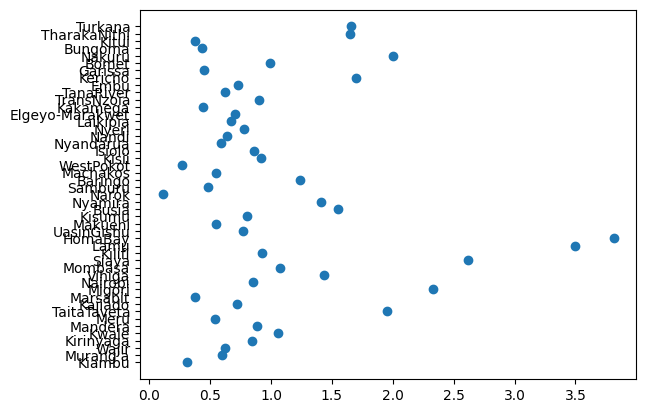

In [15]:
plt.scatter( df3["MPI"], df3["DMU"],)
plt.plot()

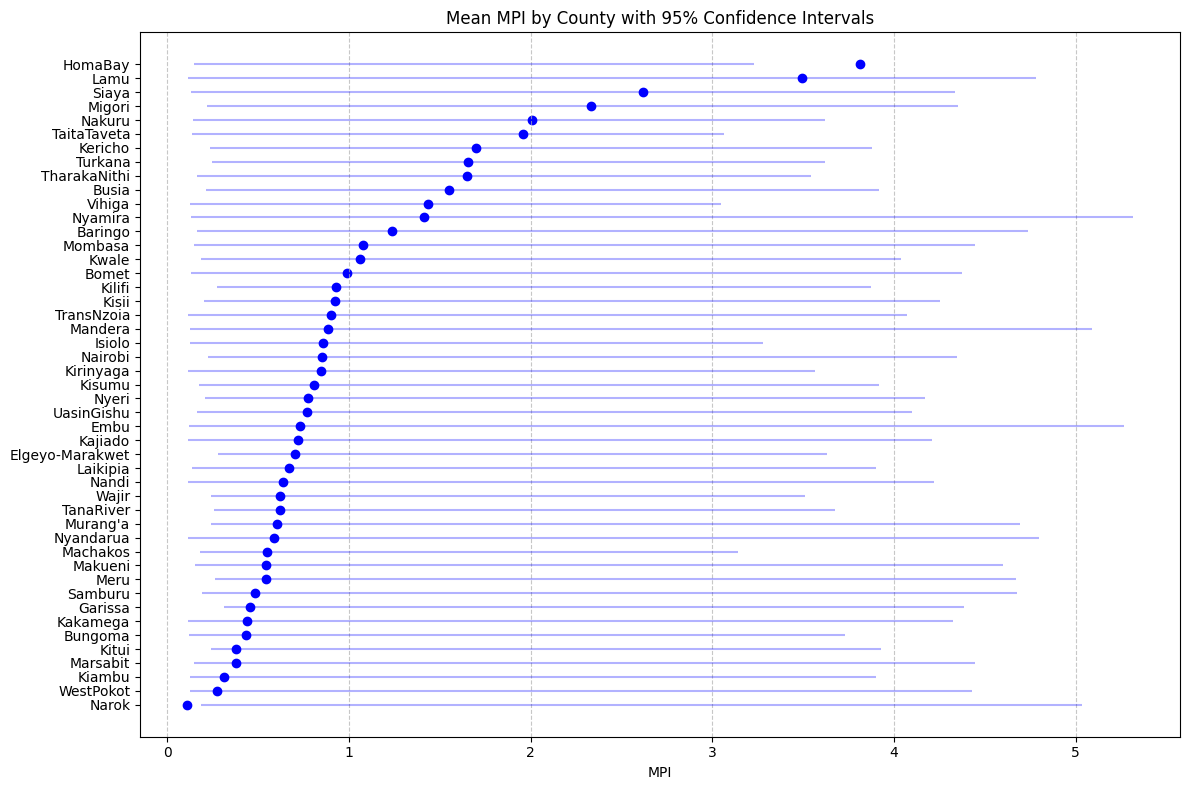

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming your dataframe is called 'df' with columns:
# 'country', 'mean_gdp', 'lower_ci', 'upper_ci'

# Sort by mean GDP to make the plot more readable
df4 = df3.sort_values('MPI', ascending=True)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the mean GDP points
ax.scatter(df4['MPI'], range(len(df4)), color='blue', label='Mean GDP')

# Plot the confidence intervals
for idx, row in df4.iterrows():
    ax.hlines(y=df4.index.get_loc(idx),
              xmin=row['MPI_CI_Lower'],
              xmax=row['MPI_CI_Upper'],
              color='blue',
              alpha=0.3)

# Customize the plot
ax.set_yticks(range(len(df4)))
ax.set_yticklabels(df4['DMU'])
ax.set_xlabel('MPI')
ax.set_title('Mean MPI by County with 95% Confidence Intervals')

# Add a grid for better readability
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.savefig("dmu1.png")
plt.show()

In [19]:
files.download("dmu1.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
import numpy as np
import pandas as pd
from pyomo.environ import (ConcreteModel, Var, Objective, Constraint,
                         SolverFactory, maximize, NonNegativeReals,
                         ConstraintList, TerminationCondition)
import numpy.random as random
import io
import os
def normalize_data(data):
    """
    Normalize data using robust scaling
    """
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    range_vals = max_vals - min_vals
    range_vals[range_vals == 0] = 1

    # Scale to [0.1, 1] range
    normalized = 0.1 + 0.9 * (data - min_vals) / range_vals
    return normalized

def calculate_efficiency_crs(inputs, outputs, frontier_inputs, frontier_outputs, solver, dmu_index=None):
    """
    Calculate efficiency scores using output-oriented CRS DEA model
    """
    # Normalize data
    norm_inputs = normalize_data(inputs)
    norm_outputs = normalize_data(outputs)
    norm_frontier_inputs = normalize_data(frontier_inputs)
    norm_frontier_outputs = normalize_data(frontier_outputs)

    efficiencies = []

    for i in range(len(inputs)):
        model = ConcreteModel()

        # Variables
        model.phi = Var(domain=NonNegativeReals, bounds=(1.0, 10.0), initialize=1.0)
        model.lambdas = Var(range(len(frontier_inputs)), domain=NonNegativeReals, bounds=(0.0, 1.0))

        # Objective: maximize phi (output efficiency)
        model.obj = Objective(expr=model.phi, sense=maximize)

        # Constraints
        model.constraints = ConstraintList()

        # Input constraints with epsilon
        epsilon = 1e-6
        for j in range(inputs.shape[1]):
            model.constraints.add(
                sum(model.lambdas[k] * norm_frontier_inputs[k, j]
                    for k in range(len(frontier_inputs))) <= norm_inputs[i, j] + epsilon
            )

        # Output constraints with epsilon
        for j in range(outputs.shape[1]):
            model.constraints.add(
                sum(model.lambdas[k] * norm_frontier_outputs[k, j]
                    for k in range(len(frontier_outputs))) >= model.phi * norm_outputs[i, j] - epsilon
            )

        try:
            result = solver.solve(model)

            if result.solver.termination_condition == TerminationCondition.optimal:
                eff_value = 1 / float(model.phi.value)  # Convert to efficiency score

                # Validate efficiency value
                if eff_value < 0.1 or eff_value > 1.0 or np.isnan(eff_value):
                    print(f"Warning: Invalid efficiency value {eff_value} for DMU {dmu_index if dmu_index is not None else i}")
                    eff_value = 1.0

                efficiencies.append(eff_value)
            else:
                print(f"Warning: Non-optimal solution for DMU {dmu_index if dmu_index is not None else i}")
                efficiencies.append(1.0)

        except Exception as e:
            print(f"Error solving DEA for DMU {dmu_index if dmu_index is not None else i}: {str(e)}")
            efficiencies.append(1.0)

    return np.array(efficiencies)

def calculate_mpi_with_decomposition(inputs_t, outputs_t, inputs_t1, outputs_t1, solver, dmu_indices=None):
    """
    Calculate MPI and its decomposition
    """
    # Calculate efficiencies
    print("\nCalculating period t efficiencies...")
    eff_t_t = calculate_efficiency_crs(inputs_t, outputs_t, inputs_t, outputs_t, solver, dmu_indices)

    print("\nCalculating period t+1 efficiencies...")
    eff_t1_t1 = calculate_efficiency_crs(inputs_t1, outputs_t1, inputs_t1, outputs_t1, solver, dmu_indices)

    print("\nCalculating cross-period efficiencies...")
    eff_t_t1 = calculate_efficiency_crs(inputs_t, outputs_t, inputs_t1, outputs_t1, solver, dmu_indices)
    eff_t1_t = calculate_efficiency_crs(inputs_t1, outputs_t1, inputs_t, outputs_t, solver, dmu_indices)

    # Handle potential numerical issues
    epsilon = 1e-10
    eff_t_t = np.maximum(eff_t_t, epsilon)
    eff_t1_t1 = np.maximum(eff_t1_t1, epsilon)
    eff_t_t1 = np.maximum(eff_t_t1, epsilon)
    eff_t1_t = np.maximum(eff_t1_t, epsilon)

    # Calculate components
    efficiency_change = eff_t1_t1 / eff_t_t
    technical_change = np.sqrt((eff_t_t / eff_t_t1) * (eff_t1_t / eff_t1_t1))
    mpi = efficiency_change * technical_change

    return mpi, technical_change, efficiency_change

def bootstrap_mpi(inputs_t, outputs_t, inputs_t1, outputs_t1, solver,
                 n_bootstrap=100, alpha=0.05):  # Further reduced bootstrap iterations
    """
    Perform bootstrap
    """
    n_dmus = len(inputs_t)
    mpi_boots = np.zeros((n_bootstrap, n_dmus))
    tech_boots = np.zeros((n_bootstrap, n_dmus))
    eff_boots = np.zeros((n_bootstrap, n_dmus))

    for b in range(n_bootstrap):
        print(f"\nBootstrap iteration {b+1}/{n_bootstrap}")

        # Generate bootstrap sample indices
        indices = random.choice(n_dmus, size=n_dmus, replace=True)

        # Get bootstrap samples
        inputs_t_boot = inputs_t[indices]
        outputs_t_boot = outputs_t[indices]
        inputs_t1_boot = inputs_t1[indices]
        outputs_t1_boot = outputs_t1[indices]

        # Calculate MPI for bootstrap sample
        mpi_b, tech_b, eff_b = calculate_mpi_with_decomposition(
            inputs_t_boot, outputs_t_boot,
            inputs_t1_boot, outputs_t1_boot,
            solver, indices
        )

        mpi_boots[b] = mpi_b
        tech_boots[b] = tech_b
        eff_boots[b] = eff_b

    # Calculate confidence intervals
    ci_lower = alpha / 2
    ci_upper = 1 - alpha / 2

    mpi_ci = np.percentile(mpi_boots, [ci_lower * 100, ci_upper * 100], axis=0)
    tech_ci = np.percentile(tech_boots, [ci_lower * 100, ci_upper * 100], axis=0)
    eff_ci = np.percentile(eff_boots, [ci_lower * 100, ci_upper * 100], axis=0)

    return mpi_ci, tech_ci, eff_ci
def bootstrap_mpi(inputs_t, outputs_t, inputs_t1, outputs_t1, solver,
                 n_bootstrap=1000, alpha=0.05):  # Increased bootstrap iterations for stability
    """
    Perform bootstrap with simplified confidence interval calculation
    """
    n_dmus = len(inputs_t)
    mpi_boots = np.zeros((n_bootstrap, n_dmus))
    tech_boots = np.zeros((n_bootstrap, n_dmus))
    eff_boots = np.zeros((n_bootstrap, n_dmus))

    # Calculate original MPI scores
    mpi_orig, tech_orig, eff_orig = calculate_mpi_with_decomposition(
        inputs_t, outputs_t, inputs_t1, outputs_t1, solver
    )

    for b in range(n_bootstrap):
        print(f"\nBootstrap iteration {b+1}/{n_bootstrap}")

        # Simple random sampling with replacement
        indices = random.choice(n_dmus, size=n_dmus, replace=True)

        # Get bootstrap samples
        inputs_t_boot = inputs_t[indices]
        outputs_t_boot = outputs_t[indices]
        inputs_t1_boot = inputs_t1[indices]
        outputs_t1_boot = outputs_t1[indices]

        # Calculate MPI for bootstrap sample
        mpi_b, tech_b, eff_b = calculate_mpi_with_decomposition(
            inputs_t_boot, outputs_t_boot,
            inputs_t1_boot, outputs_t1_boot,
            solver, indices
        )

        mpi_boots[b] = mpi_b
        tech_boots[b] = tech_b
        eff_boots[b] = eff_b

    # Calculate percentile-based confidence intervals
    mpi_ci = np.zeros((2, n_dmus))
    tech_ci = np.zeros((2, n_dmus))
    eff_ci = np.zeros((2, n_dmus))

    for i in range(n_dmus):
        # Sort bootstrap values for each DMU
        mpi_sorted = np.sort(mpi_boots[:, i])
        tech_sorted = np.sort(tech_boots[:, i])
        eff_sorted = np.sort(eff_boots[:, i])

        # Get confidence interval indices
        lower_idx = int(alpha/2 * n_bootstrap)
        upper_idx = int((1-alpha/2) * n_bootstrap)

        # Store confidence intervals
        mpi_ci[:, i] = [mpi_sorted[lower_idx], mpi_sorted[upper_idx]]
        tech_ci[:, i] = [tech_sorted[lower_idx], tech_sorted[upper_idx]]
        eff_ci[:, i] = [eff_sorted[lower_idx], eff_sorted[upper_idx]]

    return mpi_ci, tech_ci, eff_ci
def run_analysis(df):
    """
    Run the complete MPI analysis
    """
    # Initialize solver
    solver = SolverFactory('glpk', executable='/usr/bin/glpsol')

    # Split data by year
    df_2014 = df[df["year"] == 2014]
    df_2022 = df[df["year"] == 2022]

    # Prepare inputs and outputs
    input_cols = ['l_pop_dev', 'l_healthworkforce', 'l_women_education',
                 'l_water', 'l_better_nutrition']
    output_cols = ['l_childsurvival']

    inputs_2014 = df_2014[input_cols].values
    outputs_2014 = df_2014[output_cols].values
    inputs_2022 = df_2022[input_cols].values
    outputs_2022 = df_2022[output_cols].values

    # Print data info
    print("\nData shapes:")
    print(f"2014 data: {df_2014.shape}")
    print(f"2022 data: {df_2022.shape}")

    # Calculate base MPI and decomposition
    print("\nCalculating base MPI...")
    mpi, tech_change, eff_change = calculate_mpi_with_decomposition(
        inputs_2014, outputs_2014,
        inputs_2022, outputs_2022,
        solver
    )

    # Calculate bootstrap confidence intervals
    print("\nCalculating bootstrap confidence intervals...")
    mpi_ci, tech_ci, eff_ci = bootstrap_mpi(
        inputs_2014, outputs_2014,
        inputs_2022, outputs_2022,
        solver,
        n_bootstrap=100  # Reduced number of bootstrap iterations
    )

    # Create results DataFrame
    results = pd.DataFrame({
        'DMU': df_2014['dmu'],
        'MPI': mpi,
        'MPI_CI_Lower': mpi_ci[0],
        'MPI_CI_Upper': mpi_ci[1],
        'Technical_Change': tech_change,
        'Tech_CI_Lower': tech_ci[0],
        'Tech_CI_Upper': tech_ci[1],
        'Efficiency_Change': eff_change,
        'Eff_CI_Lower': eff_ci[0],
        'Eff_CI_Upper': eff_ci[1]
    })

    # Add summary statistics
    summary_stats = pd.DataFrame({
        'Statistic': ['Mean', 'Median', 'Std Dev', 'Min', 'Max'],
        'MPI': [results['MPI'].mean(), results['MPI'].median(),
                results['MPI'].std(), results['MPI'].min(), results['MPI'].max()],
        'Technical_Change': [results['Technical_Change'].mean(), results['Technical_Change'].median(),
                           results['Technical_Change'].std(), results['Technical_Change'].min(),
                           results['Technical_Change'].max()],
        'Efficiency_Change': [results['Efficiency_Change'].mean(), results['Efficiency_Change'].median(),
                            results['Efficiency_Change'].std(), results['Efficiency_Change'].min(),
                            results['Efficiency_Change'].max()]
    })

    return results, summary_stats

# Usage
if __name__ == "__main__":
    # Load data
    #df = pd.read_stata("trial_data.dta")
    df = pd.read_stata(io.BytesIO(uploaded["trial_data (1).dta"]))
    # Run analysis
    results, summary = run_analysis(df)

    # Display results
    print("\nDetailed Results:")
    print(results)

    print("\nSummary Statistics:")
    print(summary)

    # Save results
    results.to_csv("mpi_results.csv", index=False)
    summary.to_csv("mpi_summary.csv", index=False)


Data shapes:
2014 data: (47, 51)
2022 data: (47, 51)

Calculating base MPI...

Calculating period t efficiencies...

Calculating period t+1 efficiencies...

Calculating cross-period efficiencies...

Calculating bootstrap confidence intervals...

Calculating period t efficiencies...

Calculating period t+1 efficiencies...

Calculating cross-period efficiencies...

Bootstrap iteration 1/100

Calculating period t efficiencies...

Calculating period t+1 efficiencies...

Calculating cross-period efficiencies...
 37 33 17 18 17 35 30 12  1 44 42 18  1 37 40  1 23 19 30 26 43 21 16]
 37 33 17 18 17 35 30 12  1 44 42 18  1 37 40  1 23 19 30 26 43 21 16]
 37 33 17 18 17 35 30 12  1 44 42 18  1 37 40  1 23 19 30 26 43 21 16]
 37 33 17 18 17 35 30 12  1 44 42 18  1 37 40  1 23 19 30 26 43 21 16]
 37 33 17 18 17 35 30 12  1 44 42 18  1 37 40  1 23 19 30 26 43 21 16]
 37 33 17 18 17 35 30 12  1 44 42 18  1 37 40  1 23 19 30 26 43 21 16]
 37 33 17 18 17 35 30 12  1 44 42 18  1 37 40  1 23 19 30 26 

In [22]:
df3 = pd.DataFrame(results)
df3[:5]

,DMU,MPI,MPI_CI_Lower,MPI_CI_Upper,Technical_Change,Tech_CI_Lower,Tech_CI_Upper,Efficiency_Change,Eff_CI_Lower,Eff_CI_Upper
0,Kiambu,0.309045,0.124652,3.801929,0.874654,0.700358,1.456893,0.353334,0.127289,3.740756
1,Murang'a,0.600917,0.112818,4.477006,0.899552,0.709526,1.363334,0.668018,0.127279,4.594777
2,Wajir,0.621822,0.214543,4.576696,0.900672,0.655251,1.361721,0.690398,0.204948,5.468496
3,Kirinyaga,0.843103,0.185383,4.398682,0.687039,0.649345,1.377319,1.227155,0.184274,4.732499
4,Kwale,1.061028,0.193126,4.044447,1.028596,0.727969,1.458834,1.031530,0.194244,3.876550


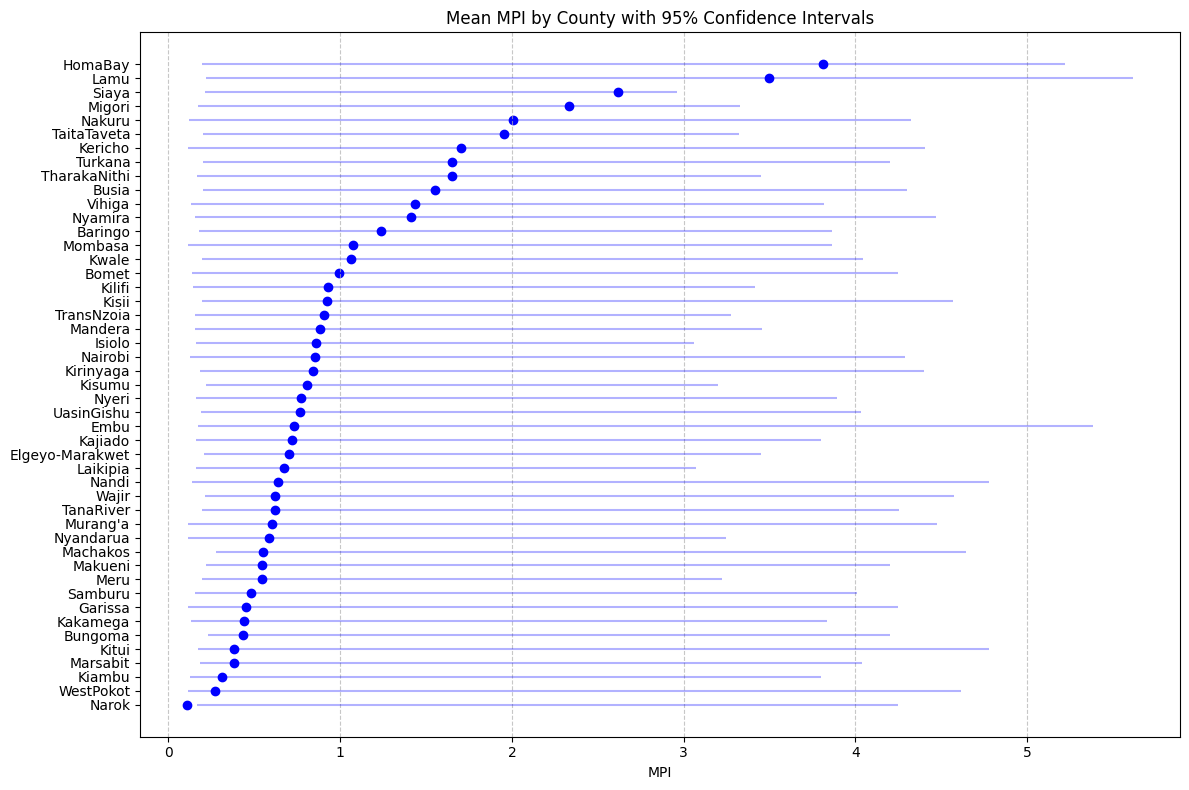

In [23]:

# Assuming your dataframe is called 'df' with columns:
# 'country', 'mean_gdp', 'lower_ci', 'upper_ci'

# Sort by mean GDP to make the plot more readable
df4 = df3.sort_values('MPI', ascending=True)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the mean GDP points
ax.scatter(df4['MPI'], range(len(df4)), color='blue', label='Mean GDP')

# Plot the confidence intervals
for idx, row in df4.iterrows():
    ax.hlines(y=df4.index.get_loc(idx),
              xmin=row['MPI_CI_Lower'],
              xmax=row['MPI_CI_Upper'],
              color='blue',
              alpha=0.3)

# Customize the plot
ax.set_yticks(range(len(df4)))
ax.set_yticklabels(df4['DMU'])
ax.set_xlabel('MPI')
ax.set_title('Mean MPI by County with 95% Confidence Intervals')

# Add a grid for better readability
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
#plt.savefig("dmu1.png")
plt.show()

In [24]:
import numpy as np
import pandas as pd
from pyomo.environ import (ConcreteModel, Var, Objective, Constraint,
                         SolverFactory, maximize, NonNegativeReals,
                         ConstraintList, TerminationCondition)
import numpy.random as random
import io
import os
def normalize_data(data):
    """
    Normalize data using robust scaling
    """
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    range_vals = max_vals - min_vals
    range_vals[range_vals == 0] = 1

    # Scale to [0.1, 1] range
    normalized = 0.1 + 0.9 * (data - min_vals) / range_vals
    return normalized

def calculate_efficiency_crs(inputs, outputs, frontier_inputs, frontier_outputs, solver, dmu_index=None):
    """
    Calculate efficiency scores using output-oriented CRS DEA model
    """
    # Normalize data
    norm_inputs = normalize_data(inputs)
    norm_outputs = normalize_data(outputs)
    norm_frontier_inputs = normalize_data(frontier_inputs)
    norm_frontier_outputs = normalize_data(frontier_outputs)

    efficiencies = []

    for i in range(len(inputs)):
        model = ConcreteModel()

        # Variables
        model.phi = Var(domain=NonNegativeReals, bounds=(1.0, 10.0), initialize=1.0)
        model.lambdas = Var(range(len(frontier_inputs)), domain=NonNegativeReals, bounds=(0.0, 1.0))

        # Objective: maximize phi (output efficiency)
        model.obj = Objective(expr=model.phi, sense=maximize)

        # Constraints
        model.constraints = ConstraintList()

        # Input constraints with epsilon
        epsilon = 1e-6
        for j in range(inputs.shape[1]):
            model.constraints.add(
                sum(model.lambdas[k] * norm_frontier_inputs[k, j]
                    for k in range(len(frontier_inputs))) <= norm_inputs[i, j] + epsilon
            )

        # Output constraints with epsilon
        for j in range(outputs.shape[1]):
            model.constraints.add(
                sum(model.lambdas[k] * norm_frontier_outputs[k, j]
                    for k in range(len(frontier_outputs))) >= model.phi * norm_outputs[i, j] - epsilon
            )

        try:
            result = solver.solve(model)

            if result.solver.termination_condition == TerminationCondition.optimal:
                eff_value = 1 / float(model.phi.value)  # Convert to efficiency score

                # Validate efficiency value
                if eff_value < 0.1 or eff_value > 1.0 or np.isnan(eff_value):
                    print(f"Warning: Invalid efficiency value {eff_value} for DMU {dmu_index if dmu_index is not None else i}")
                    eff_value = 1.0

                efficiencies.append(eff_value)
            else:
                print(f"Warning: Non-optimal solution for DMU {dmu_index if dmu_index is not None else i}")
                efficiencies.append(1.0)

        except Exception as e:
            print(f"Error solving DEA for DMU {dmu_index if dmu_index is not None else i}: {str(e)}")
            efficiencies.append(1.0)

    return np.array(efficiencies)

def calculate_mpi_with_decomposition(inputs_t, outputs_t, inputs_t1, outputs_t1, solver, dmu_indices=None):
    """
    Calculate MPI and its decomposition
    """
    # Calculate efficiencies
    print("\nCalculating period t efficiencies...")
    eff_t_t = calculate_efficiency_crs(inputs_t, outputs_t, inputs_t, outputs_t, solver, dmu_indices)

    print("\nCalculating period t+1 efficiencies...")
    eff_t1_t1 = calculate_efficiency_crs(inputs_t1, outputs_t1, inputs_t1, outputs_t1, solver, dmu_indices)

    print("\nCalculating cross-period efficiencies...")
    eff_t_t1 = calculate_efficiency_crs(inputs_t, outputs_t, inputs_t1, outputs_t1, solver, dmu_indices)
    eff_t1_t = calculate_efficiency_crs(inputs_t1, outputs_t1, inputs_t, outputs_t, solver, dmu_indices)

    # Handle potential numerical issues
    epsilon = 1e-10
    eff_t_t = np.maximum(eff_t_t, epsilon)
    eff_t1_t1 = np.maximum(eff_t1_t1, epsilon)
    eff_t_t1 = np.maximum(eff_t_t1, epsilon)
    eff_t1_t = np.maximum(eff_t1_t, epsilon)

    # Calculate components
    efficiency_change = eff_t1_t1 / eff_t_t
    technical_change = np.sqrt((eff_t_t / eff_t_t1) * (eff_t1_t / eff_t1_t1))
    mpi = efficiency_change * technical_change

    return mpi, technical_change, efficiency_change


def bootstrap_mpi(inputs_t, outputs_t, inputs_t1, outputs_t1, solver,
                 n_bootstrap=1000, alpha=0.05):
    """
    Perform bootstrap with corrected confidence interval calculation
    """
    n_dmus = len(inputs_t)
    mpi_boots = np.zeros((n_bootstrap, n_dmus))
    tech_boots = np.zeros((n_bootstrap, n_dmus))
    eff_boots = np.zeros((n_bootstrap, n_dmus))

    # Calculate original values
    mpi_orig, tech_orig, eff_orig = calculate_mpi_with_decomposition(
        inputs_t, outputs_t, inputs_t1, outputs_t1, solver
    )

    for b in range(n_bootstrap):
        print(f"\nBootstrap iteration {b+1}/{n_bootstrap}")
        indices = random.choice(n_dmus, size=n_dmus, replace=True)

        inputs_t_boot = inputs_t[indices]
        outputs_t_boot = outputs_t[indices]
        inputs_t1_boot = inputs_t1[indices]
        outputs_t1_boot = outputs_t1[indices]

        mpi_b, tech_b, eff_b = calculate_mpi_with_decomposition(
            inputs_t_boot, outputs_t_boot,
            inputs_t1_boot, outputs_t1_boot,
            solver, indices
        )

        mpi_boots[b] = mpi_b
        tech_boots[b] = tech_b
        eff_boots[b] = eff_b

    # Calculate bias-corrected confidence intervals
    mpi_ci = np.zeros((2, n_dmus))
    tech_ci = np.zeros((2, n_dmus))
    eff_ci = np.zeros((2, n_dmus))

    for i in range(n_dmus):
        # For each index, calculate bias-corrected intervals
        mpi_bias = np.mean(mpi_boots[:, i]) - mpi_orig[i]
        mpi_sorted = np.sort(mpi_boots[:, i])

        # Adjust percentiles based on bias
        if mpi_bias < 0:
            # If bootstrap mean is less than original, adjust lower bound
            lower_pct = max(alpha/2, alpha)
            upper_pct = 1 - alpha/2
        else:
            # If bootstrap mean is greater, use standard percentiles
            lower_pct = alpha/2
            upper_pct = 1 - alpha/2

        lower_idx = int(lower_pct * n_bootstrap)
        upper_idx = int(upper_pct * n_bootstrap)

        mpi_ci[:, i] = [mpi_sorted[lower_idx], mpi_sorted[upper_idx]]

        # Repeat for technical change and efficiency change
        tech_bias = np.mean(tech_boots[:, i]) - tech_orig[i]
        tech_sorted = np.sort(tech_boots[:, i])

        if tech_bias < 0:
            lower_pct = max(alpha/2, alpha)
            upper_pct = 1 - alpha/2
        else:
            lower_pct = alpha/2
            upper_pct = 1 - alpha/2

        lower_idx = int(lower_pct * n_bootstrap)
        upper_idx = int(upper_pct * n_bootstrap)

        tech_ci[:, i] = [tech_sorted[lower_idx], tech_sorted[upper_idx]]

        eff_bias = np.mean(eff_boots[:, i]) - eff_orig[i]
        eff_sorted = np.sort(eff_boots[:, i])

        if eff_bias < 0:
            lower_pct = max(alpha/2, alpha)
            upper_pct = 1 - alpha/2
        else:
            lower_pct = alpha/2
            upper_pct = 1 - alpha/2

        lower_idx = int(lower_pct * n_bootstrap)
        upper_idx = int(upper_pct * n_bootstrap)

        eff_ci[:, i] = [eff_sorted[lower_idx], eff_sorted[upper_idx]]

    return mpi_ci, tech_ci, eff_ci
def run_analysis(df):
    """
    Run the complete MPI analysis
    """
    # Initialize solver
    solver = SolverFactory('glpk', executable='/usr/bin/glpsol')

    # Split data by year
    df_2014 = df[df["year"] == 2014]
    df_2022 = df[df["year"] == 2022]

    # Prepare inputs and outputs
    input_cols = ['l_pop_dev', 'l_healthworkforce', 'l_women_education',
                 'l_water', 'l_better_nutrition']
    output_cols = ['l_childsurvival']

    inputs_2014 = df_2014[input_cols].values
    outputs_2014 = df_2014[output_cols].values
    inputs_2022 = df_2022[input_cols].values
    outputs_2022 = df_2022[output_cols].values

    # Print data info
    print("\nData shapes:")
    print(f"2014 data: {df_2014.shape}")
    print(f"2022 data: {df_2022.shape}")

    # Calculate base MPI and decomposition
    print("\nCalculating base MPI...")
    mpi, tech_change, eff_change = calculate_mpi_with_decomposition(
        inputs_2014, outputs_2014,
        inputs_2022, outputs_2022,
        solver
    )

    # Calculate bootstrap confidence intervals
    print("\nCalculating bootstrap confidence intervals...")
    mpi_ci, tech_ci, eff_ci = bootstrap_mpi(
        inputs_2014, outputs_2014,
        inputs_2022, outputs_2022,
        solver,
        n_bootstrap=100  # Reduced number of bootstrap iterations
    )

    # Create results DataFrame
    results = pd.DataFrame({
        'DMU': df_2014['dmu'],
        'MPI': mpi,
        'MPI_CI_Lower': mpi_ci[0],
        'MPI_CI_Upper': mpi_ci[1],
        'Technical_Change': tech_change,
        'Tech_CI_Lower': tech_ci[0],
        'Tech_CI_Upper': tech_ci[1],
        'Efficiency_Change': eff_change,
        'Eff_CI_Lower': eff_ci[0],
        'Eff_CI_Upper': eff_ci[1]
    })

    # Add summary statistics
    summary_stats = pd.DataFrame({
        'Statistic': ['Mean', 'Median', 'Std Dev', 'Min', 'Max'],
        'MPI': [results['MPI'].mean(), results['MPI'].median(),
                results['MPI'].std(), results['MPI'].min(), results['MPI'].max()],
        'Technical_Change': [results['Technical_Change'].mean(), results['Technical_Change'].median(),
                           results['Technical_Change'].std(), results['Technical_Change'].min(),
                           results['Technical_Change'].max()],
        'Efficiency_Change': [results['Efficiency_Change'].mean(), results['Efficiency_Change'].median(),
                            results['Efficiency_Change'].std(), results['Efficiency_Change'].min(),
                            results['Efficiency_Change'].max()]
    })

    return results, summary_stats

# Usage
if __name__ == "__main__":
    # Load data
    #df = pd.read_stata("trial_data.dta")
    df = pd.read_stata(io.BytesIO(uploaded["trial_data (1).dta"]))
    # Run analysis
    results, summary = run_analysis(df)

    # Display results
    print("\nDetailed Results:")
    print(results)

    print("\nSummary Statistics:")
    print(summary)

    # Save results
    results.to_csv("mpi_results.csv", index=False)
    summary.to_csv("mpi_summary.csv", index=False)


Data shapes:
2014 data: (47, 51)
2022 data: (47, 51)

Calculating base MPI...

Calculating period t efficiencies...

Calculating period t+1 efficiencies...

Calculating cross-period efficiencies...

Calculating bootstrap confidence intervals...

Calculating period t efficiencies...

Calculating period t+1 efficiencies...

Calculating cross-period efficiencies...

Bootstrap iteration 1/100

Calculating period t efficiencies...

Calculating period t+1 efficiencies...

Calculating cross-period efficiencies...
 40  4 30 22 23 26 34  3 26 30 15  9 33 44 20  2 40 35 38 34  9 19 10]
 40  4 30 22 23 26 34  3 26 30 15  9 33 44 20  2 40 35 38 34  9 19 10]
 40  4 30 22 23 26 34  3 26 30 15  9 33 44 20  2 40 35 38 34  9 19 10]
 40  4 30 22 23 26 34  3 26 30 15  9 33 44 20  2 40 35 38 34  9 19 10]
 40  4 30 22 23 26 34  3 26 30 15  9 33 44 20  2 40 35 38 34  9 19 10]
 40  4 30 22 23 26 34  3 26 30 15  9 33 44 20  2 40 35 38 34  9 19 10]
 40  4 30 22 23 26 34  3 26 30 15  9 33 44 20  2 40 35 38 34 

In [25]:
df3 = pd.DataFrame(results)
df3[:5]

,DMU,MPI,MPI_CI_Lower,MPI_CI_Upper,Technical_Change,Tech_CI_Lower,Tech_CI_Upper,Efficiency_Change,Eff_CI_Lower,Eff_CI_Upper
0,Kiambu,0.309045,0.115583,4.536721,0.874654,0.655773,1.336297,0.353334,0.123128,4.850945
1,Murang'a,0.600917,0.215440,4.318750,0.899552,0.672236,1.378010,0.668018,0.212728,5.329599
2,Wajir,0.621822,0.111625,4.571502,0.900672,0.696585,1.355289,0.690398,0.114216,5.144042
3,Kirinyaga,0.843103,0.110499,3.253958,0.687039,0.677098,1.406713,1.227155,0.130903,3.105766
4,Kwale,1.061028,0.185436,3.640306,1.028596,0.729034,1.320765,1.031530,0.194923,4.583641


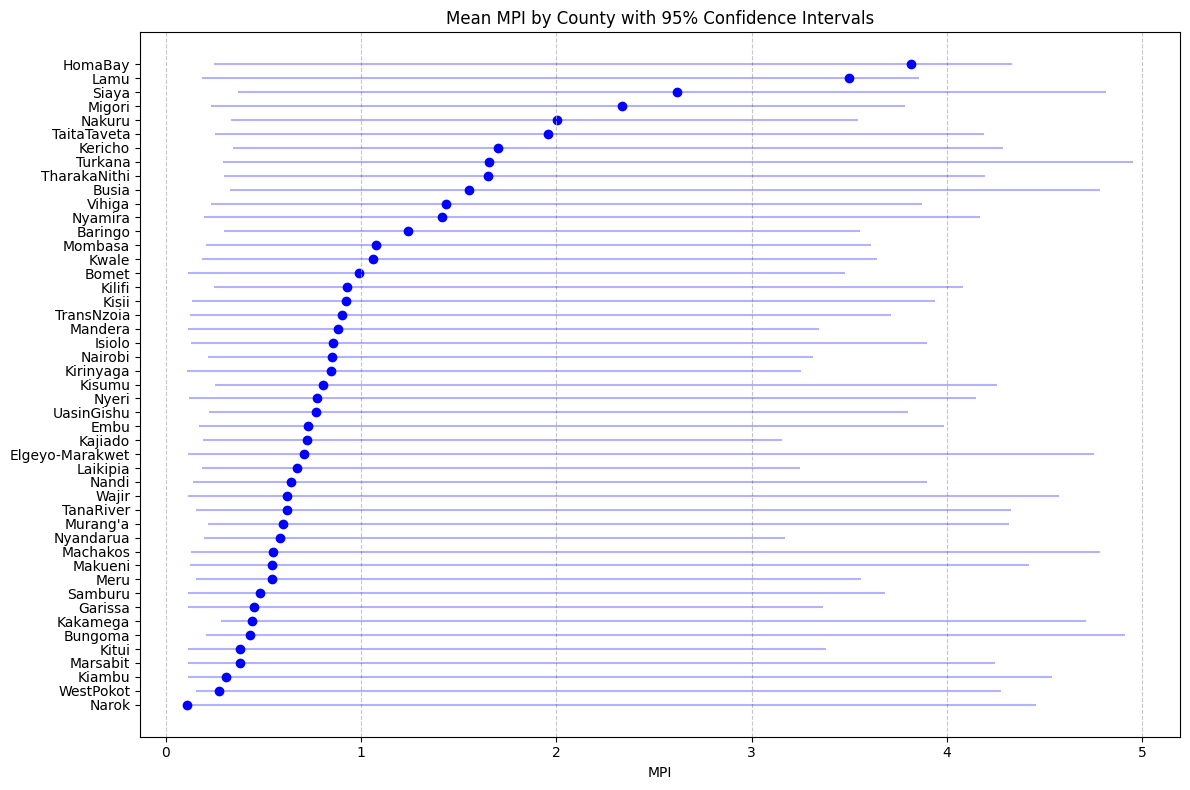

In [26]:
# Sort by mean GDP to make the plot more readable
df4 = df3.sort_values('MPI', ascending=True)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the mean GDP points
ax.scatter(df4['MPI'], range(len(df4)), color='blue', label='Mean GDP')

# Plot the confidence intervals
for idx, row in df4.iterrows():
    ax.hlines(y=df4.index.get_loc(idx),
              xmin=row['MPI_CI_Lower'],
              xmax=row['MPI_CI_Upper'],
              color='blue',
              alpha=0.3)

# Customize the plot
ax.set_yticks(range(len(df4)))
ax.set_yticklabels(df4['DMU'])
ax.set_xlabel('MPI')
ax.set_title('Mean MPI by County with 95% Confidence Intervals')

# Add a grid for better readability
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
#plt.savefig("dmu1.png")
plt.show()

In [27]:
df3.columns

Index(['DMU', 'MPI', 'MPI_CI_Lower', 'MPI_CI_Upper', 'Technical_Change',
       'Tech_CI_Lower', 'Tech_CI_Upper', 'Efficiency_Change', 'Eff_CI_Lower',
       'Eff_CI_Upper'],
      dtype='object')

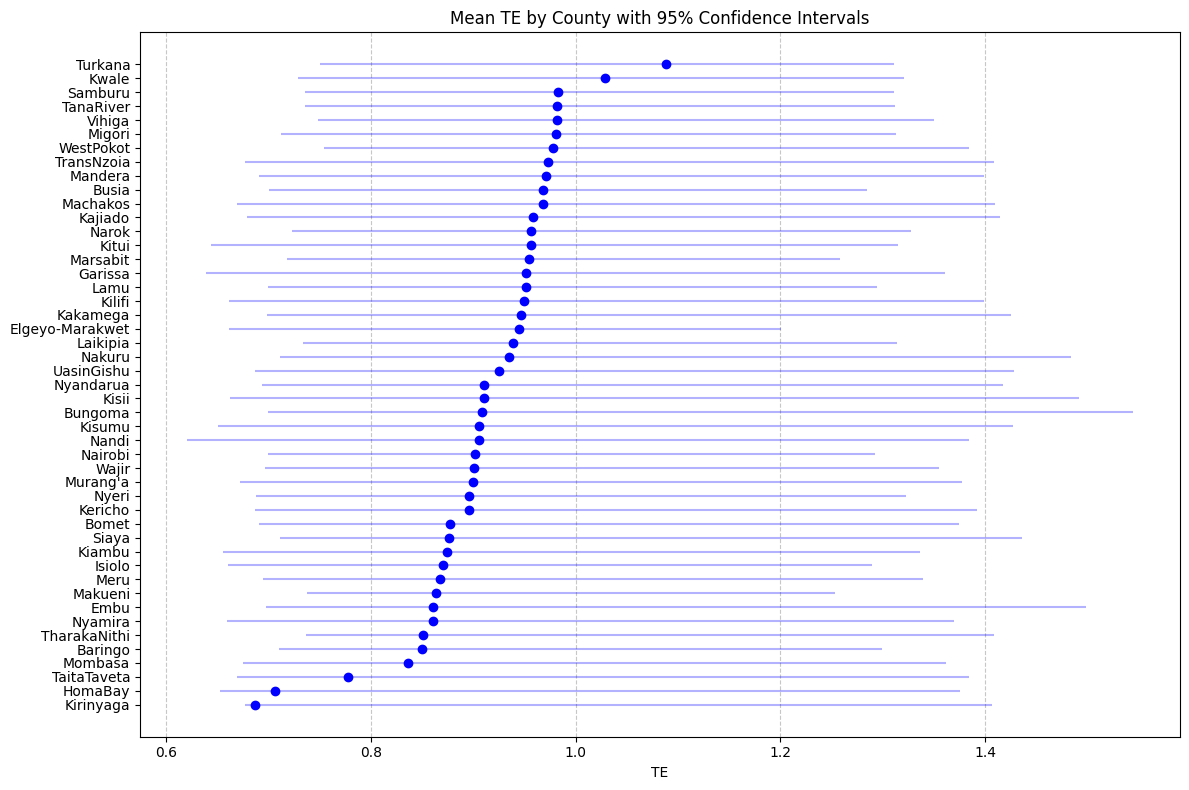

In [28]:
# Sort by mean GDP to make the plot more readable
df4 = df3.sort_values('Technical_Change', ascending=True)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the mean GDP points
ax.scatter(df4['Technical_Change'], range(len(df4)), color='blue', label='Mean GDP')

# Plot the confidence intervals
for idx, row in df4.iterrows():
    ax.hlines(y=df4.index.get_loc(idx),
              xmin=row['Tech_CI_Lower'],
              xmax=row['Tech_CI_Upper'],
              color='blue',
              alpha=0.3)

# Customize the plot
ax.set_yticks(range(len(df4)))
ax.set_yticklabels(df4['DMU'])
ax.set_xlabel('TE')
ax.set_title('Mean TE by County with 95% Confidence Intervals')

# Add a grid for better readability
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
#plt.savefig("dmu1.png")
plt.show()

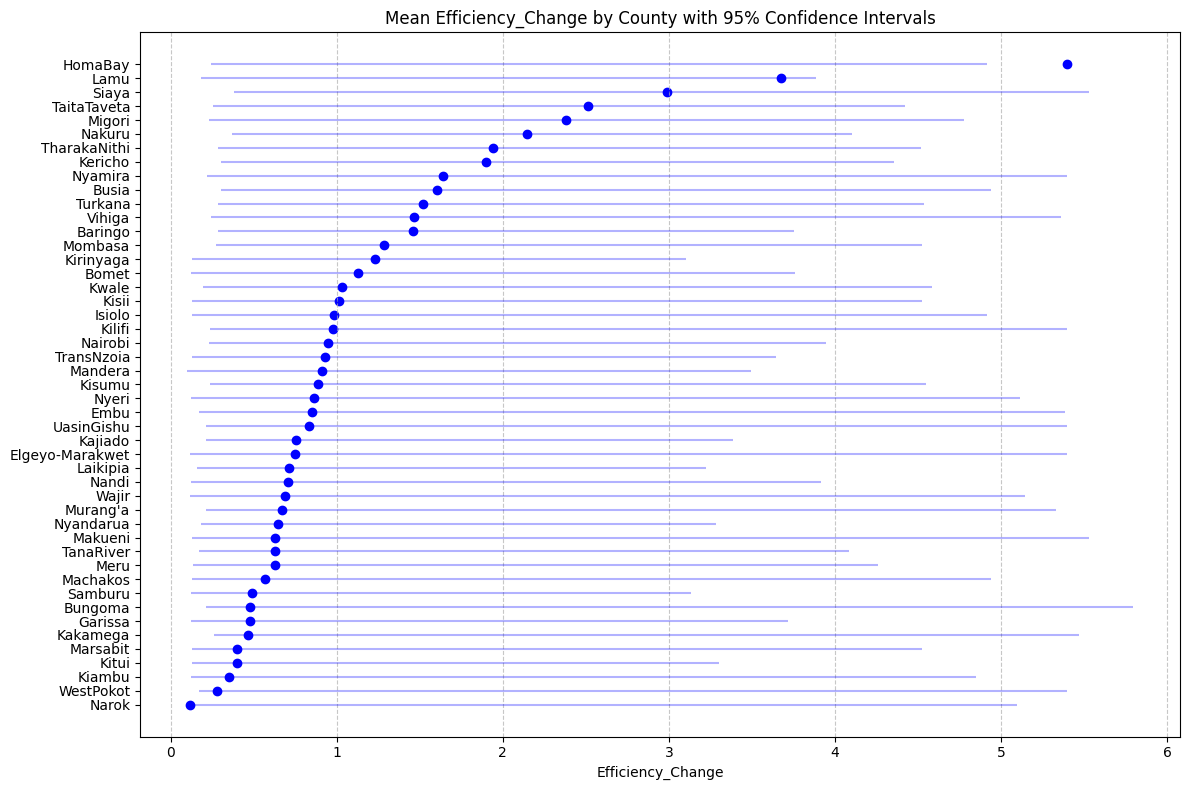

In [29]:
# Sort by mean GDP to make the plot more readable
df4 = df3.sort_values('Efficiency_Change', ascending=True)

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the mean GDP points
ax.scatter(df4['Efficiency_Change'], range(len(df4)), color='blue', label='Mean GDP')

# Plot the confidence intervals
for idx, row in df4.iterrows():
    ax.hlines(y=df4.index.get_loc(idx),
              xmin=row['Eff_CI_Lower'],
              xmax=row['Eff_CI_Upper'],
              color='blue',
              alpha=0.3)

# Customize the plot
ax.set_yticks(range(len(df4)))
ax.set_yticklabels(df4['DMU'])
ax.set_xlabel('Efficiency_Change')
ax.set_title('Mean Efficiency_Change by County with 95% Confidence Intervals')

# Add a grid for better readability
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
#plt.savefig("dmu1.png")
plt.show()

In [30]:
summary

,Statistic,MPI,Technical_Change,Efficiency_Change
0,Mean,1.049294,0.914160,1.176726
1,Median,0.804979,0.910913,0.888991
2,Std Dev,0.782259,0.072042,0.963044
3,Min,0.109995,0.687039,0.115046
4,Max,3.812711,1.088737,5.398494


In [31]:
df3["MPI"].mean()

1.049293523577044